In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')

In [12]:
print(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 colum

# Разбор целевой переменной

In [19]:
df_train['exam_score'].describe()

count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64

**По графику мы может увидеть, что целевая переменная имеет нормальное распределение, не имеет выбросов. Но "20" и "100" имеют большое скопление результатов, это указывает на то, что +-20 и 100 являются минимальным и максимальным балом экзамена.** 

Лучшим вариантом здесь будет использовать ансамбль моделей, в котором одна модель будет предсказывать группу(на которые в будущем я поделю датасет), другая условный бал внутри группы

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

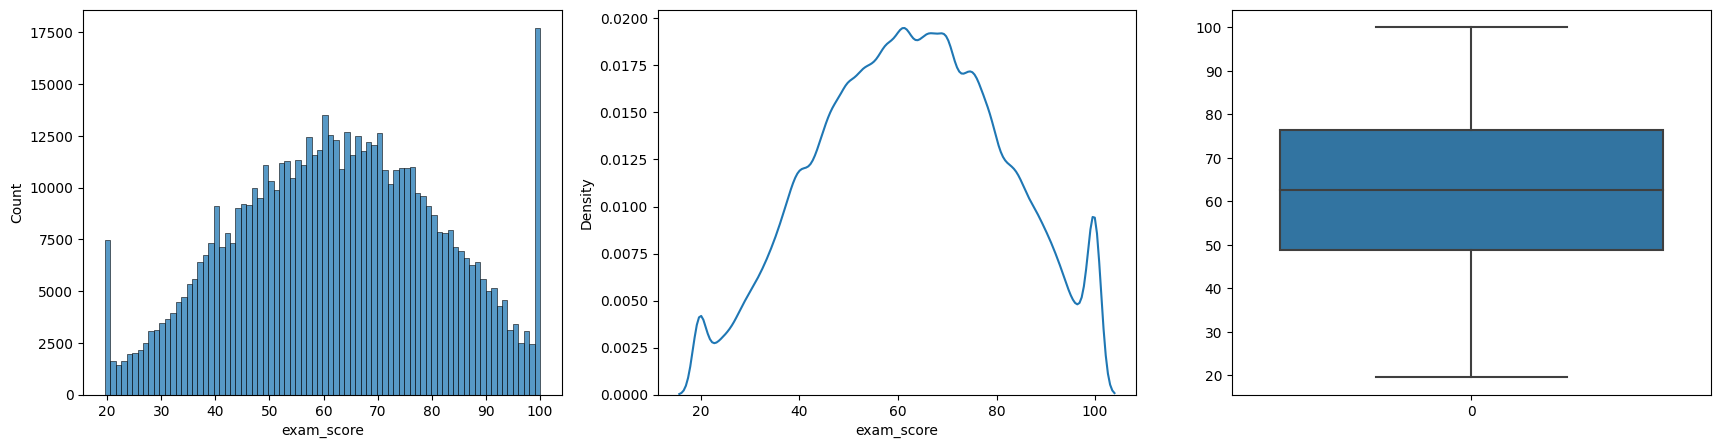

In [26]:
fig, axes = plt.subplots(1,3, figsize = (21,5))
sns.histplot(data = df_train, x = 'exam_score', bins = 80, ax = axes[0])
sns.kdeplot(data = df_train, x = 'exam_score', ax = axes[1])
sns.boxplot(data = df_train['exam_score'], ax = axes[2])

На матрице корреляций мы видим умеренную зависимость целевой переменной от других

study_hours(0.76)

class_attendance(0.36)

sleep_hours(0.17)

Позже после FE, мы проверим корреляцию и с другими переменными

<Axes: >

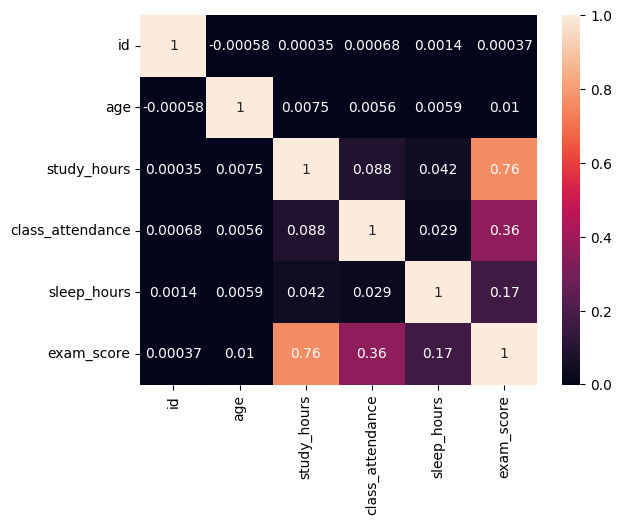

In [44]:
sns.heatmap(df_train.corr(numeric_only = True), annot = True)

Пишем функцю, которая разделит весь датасет на три группы. Для того чтобы более подробно расмотреть различие между ними.

In [27]:
def groupbyexam(df):
    return df['exam_group'] = df['exam_score'].apply(lambda x: 'min' if x < 25 else ('max' if x == 100 else 'mid'))

In [30]:
groupbyexam(df_train)

In [33]:
df_train.groupby('exam_group').mean(numeric_only = True)

,id,age,study_hours,class_attendance,sleep_hours,exam_score
exam_group,,,,,,
max,314578.781537,20.746021,7.141599,85.792852,7.867609,100.000000
mid,315048.069903,20.552249,3.998127,72.019923,7.074925,62.540997
min,313442.845424,20.067799,0.839271,55.965556,6.138480,21.238250


# Изучение категориальных столбцов

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
 13  exam_group        630000 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 67.3+ MB


Количество уникальных значений у каждой(не числовой) колонки в DF

In [53]:
for col in df_train.select_dtypes(exclude = ['int64', 'float64']).columns:
    un_val = df_train[col].unique()
    print(f'{col}: {len(un_val)}')

gender: 3
course: 7
internet_access: 2
sleep_quality: 3
study_method: 5
facility_rating: 3
exam_difficulty: 3
exam_group: 3


# Feature Engineering